In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [3]:
base_csv = './data/IMDB Dataset.csv'
df = pd.read_csv(base_csv)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
import numpy as np

def load_glove_embeddings(glove_file_path):
    embedding_dict = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]  # The word
            vector = np.asarray(values[1:], dtype='float32')  # The embedding vector
            embedding_dict[word] = vector
    return embedding_dict

# Example usage:
glove_file_path = "./data/glove.6B.50d.txt"  # Replace with the path to your GloVe file
embedding_dict = load_glove_embeddings(glove_file_path)
print(f"Loaded {len(embedding_dict)} word vectors.")

Loaded 400000 word vectors.


In [12]:
import pandas as pd
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords

# Download NLTK stop words (if not already downloaded)
nltk.download('stopwords')
# Preprocess the text to extract the vocabulary
def preprocess_text(text):
    # Step 1: Remove HTML tags (e.g., <br />, <div>, etc.)
    text = re.sub(r'<.*?>', '', text)
    
    # Step 2: Remove non-alphanumeric characters (only keep letters, numbers, and spaces)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # Step 3: Convert to lowercase
    text = text.lower()
    
    # Step 4: Remove extra whitespace
    text = text.strip()
    
    # Step 5: Tokenize and remove stop words
    stop_words = set(stopwords.words('english'))  # Set of English stopwords
    text_tokens = text.split()  # Split text into words
    filtered_text = [word for word in text_tokens if word not in stop_words]
        
    # Step 6: Join words back into a single string
    text = ' '.join(filtered_text)
    
    return text

# Tokenize and build the vocabulary
def build_vocab(dataframe, column_name):
    word_list = []
    for review in dataframe[column_name]:
        processed_review = preprocess_text(review)
        word_list.extend(processed_review.split())
    # Count word frequencies
    word_counts = Counter(word_list)
    return word_counts


vocab = build_vocab(df, 'review')
print(f"Vocabulary size: {len(vocab)}")

[nltk_data] Downloading package stopwords to /Users/jack/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Vocabulary size: 221464


In [13]:
# Create a word-to-index dictionary
word_to_index = {word: i+1 for i, word in enumerate(vocab.keys())}  # Start indexing from 1
print(f"Word to index mapping: {list(word_to_index.items())[:10]}")  # Show the first 10 mappings

Word to index mapping: [('one', 1), ('reviewers', 2), ('mentioned', 3), ('watching', 4), ('1', 5), ('oz', 6), ('episode', 7), ('youll', 8), ('hooked', 9), ('right', 10)]


In [14]:
embedding_dim = 50  # GloVe embedding dimension (e.g., 100 for "glove.6B.100d.txt")

# Create the embedding matrix
embedding_matrix = np.zeros((len(word_to_index) + 1, embedding_dim))  # +1 for padding (index 0)

for word, i in word_to_index.items():
    embedding_vector = embedding_dict.get(word)  # Get the GloVe vector for the word
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector  # Add the GloVe vector to the matrix
    else:
        embedding_matrix[i] = np.random.uniform(-0.01, 0.01, embedding_dim)  # Random initialization

print(f"Embedding matrix shape: {embedding_matrix.shape}")

Embedding matrix shape: (221465, 50)


In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Convert reviews to sequences of integers
def text_to_sequence(text, word_to_index):
    processed_text = preprocess_text(text)
    return [word_to_index[word] for word in processed_text.split() if word in word_to_index]

# Tokenize the reviews
df['review_sequences'] = df['review'].apply(lambda x: text_to_sequence(x, word_to_index))
df['label_convert'] = df['sentiment'].apply(lambda x: 1 if x =='positive' else 0)

In [16]:
# Train-test split with shuffle
X_train, y_train, X_test, y_test = train_test_split(df['review_sequences'], df['label_convert'], test_size=0.2, random_state=42, shuffle=True)
# Pad the sequences to a fixed length
max_length = 100  # Maximum sequence length
x_train_pad = pad_sequences(X_train, maxlen=max_length, padding='post', truncating='post')
y_train_pad = pad_sequences(y_train, maxlen=max_length, padding='post', truncating='post')

print(f"Padded sequences shape: {x_train_pad.shape}")
print("Padded Array:", x_train_pad)
print("Padded Array:", y_train_pad)

Padded sequences shape: (40000, 100)
Padded Array: [[  626  1251  3129 ...   214 27947 10648]
 [  336   158   295 ...   919  3196  2333]
 [ 4438   332   420 ...     0     0     0]
 ...
 [ 2207     1  1167 ...     0     0     0]
 [  146   878  1069 ...     0     0     0]
 [ 3266   295  1204 ...     0     0     0]]
Padded Array: [[   186    607  84411 ...    239   1456 106497]
 [   251   2249     88 ...   2120   3037   4395]
 [   306   4404    380 ...      0      0      0]
 ...
 [   747  63135    565 ...     81   2623   7873]
 [    79    573     23 ...      0      0      0]
 [   103   4795    259 ...      0      0      0]]


In [17]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(X_test.values))
valid_data = TensorDataset(torch.from_numpy(y_train_pad), torch.from_numpy(y_test.values))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [18]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 100])
Sample input: 
 tensor([[ 9926,  3730,     1,  ...,  1868,  2506,  6918],
        [  412,  4172,  4049,  ...,  1738,  2293,   673],
        [40334,   667,  4640,  ..., 40342,  1039, 34400],
        ...,
        [  314,  1221,     2,  ...,   306,  1912, 26097],
        [  417,   387,   651,  ...,  4618,  4451,  6203],
        [  845,  7509,   300,  ...,  4068,  1669,   215]], dtype=torch.int32)
Sample input: 
 tensor([1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0,
        0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
        0, 1])


In [28]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers, vocab_size, hidden_dim, embedding_dim, drop_prob, output_dim):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(drop_prob)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

              

In [30]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256
drop_prob = 0.5


model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob,output_dim)

#moving to gpu
model.to(device)

print(model)


SentimentRNN(
  (embedding): Embedding(221465, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [31]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()


In [32]:
clip = 5
epochs = 10 
valid_loss_min = np.inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), './working/state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')
    

Epoch 1
train_loss : 0.6922471735626459 val_loss : 0.6935291087627411
train_accuracy : 51.73 val_accuracy : 50.55
Validation loss decreased (inf --> 0.693529).  Saving model ...


KeyboardInterrupt: 

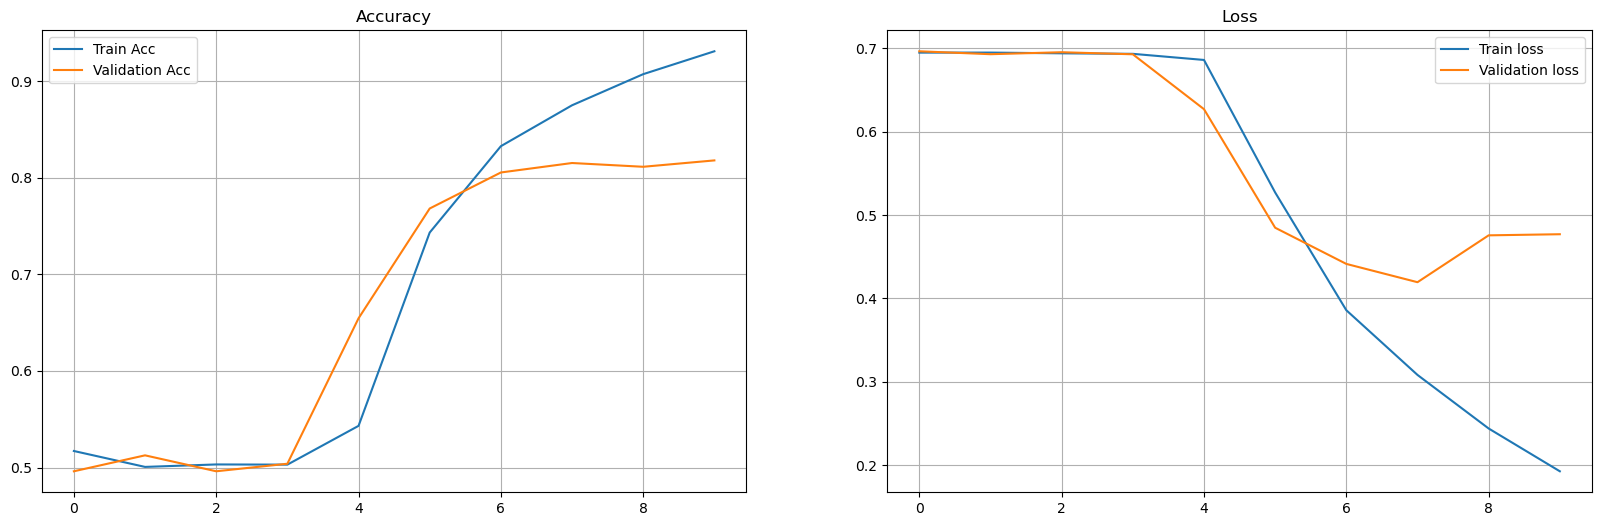

In [40]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()